# Expanding Regression

Packages

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

## Prep Data

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\QualityShocks\root\src")
from ExpandingSampleRegression import ExpandingOLS

In [3]:
def _get_rtn(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "date").
        assign(
            yhat       = lambda x: (x.beta * x.VIX_shock) + x.alpha,
            resid      = lambda x: x.value - x.yhat,
            lag_resid  = lambda x: x.resid.shift(),
            signal_rtn = lambda x: np.sign(x.lag_resid) * x.value))
    
    return df_out

def get_expanding_rtn() -> pd.DataFrame: 

    df_out = (ExpandingOLS().get_expanding_ols().groupby(
        "variable").
        apply(_get_rtn).
        reset_index(drop = True))
    
    return df_out

df_ex_rtn = get_expanding_rtn()

In [4]:
def _get_rtn(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df.set_index(
        "date").
        sort_index().
        assign(
            fs_rtn    = lambda x: np.sign(x.lag_resid) * x.value,
            yhat      = lambda x: (x.beta * x.VIX_shock) + x.const,
            resid     = lambda x: x.value - x.yhat,
            lag_resid = lambda x: x.resid.shift(),
            bs_rtn    = lambda x: np.sign(x.lag_resid) * x.value)
        [["value", "fs_rtn", "bs_rtn"]])
    
    return df_out

def get_bs_rtn() -> pd.DataFrame: 
    
    df_full_sample = (ExpandingOLS().get_full_sample_ols())

    df_sharpe = ExpandingOLS().get_bootsrapped_sharpe()
    df_min_sharpe = (df_sharpe.drop(
        columns = ["sim"]).
        groupby("variable").
        min().
        merge(right = df_sharpe, how = "inner", on = ["variable", "sharpe"]))

    df_tmp = (ExpandingOLS().bootstrap_ols().merge(
        right = df_min_sharpe, how = "inner", on = ["variable", "sim"])
        [["variable", "index", "val"]].
        rename(columns = {"index": "param"}).
        pivot(index = "variable", columns = "param", values = "val").
        rename(columns = {"VIX_shock": "beta"}).
        merge(right = df_full_sample, how = "inner", on = ["variable"]))

    df_out = (df_tmp.groupby(
        "variable").
        apply(_get_rtn).
        reset_index())
    
    return df_out

df_bs_rtn = get_bs_rtn()

def get_all(df_bs_rtn: pd.DataFrame, df_ex_rtn: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df_bs_rtn.merge(
        right = df_ex_rtn, how = "inner", on = ["date", "variable", "value"])
        [["variable", "date", "fs_rtn", "bs_rtn", "signal_rtn", "value"]].
        rename(columns = {"signal_rtn": "ex_rtn"}))
    
    return df_out

df = get_all(df_bs_rtn, df_ex_rtn)

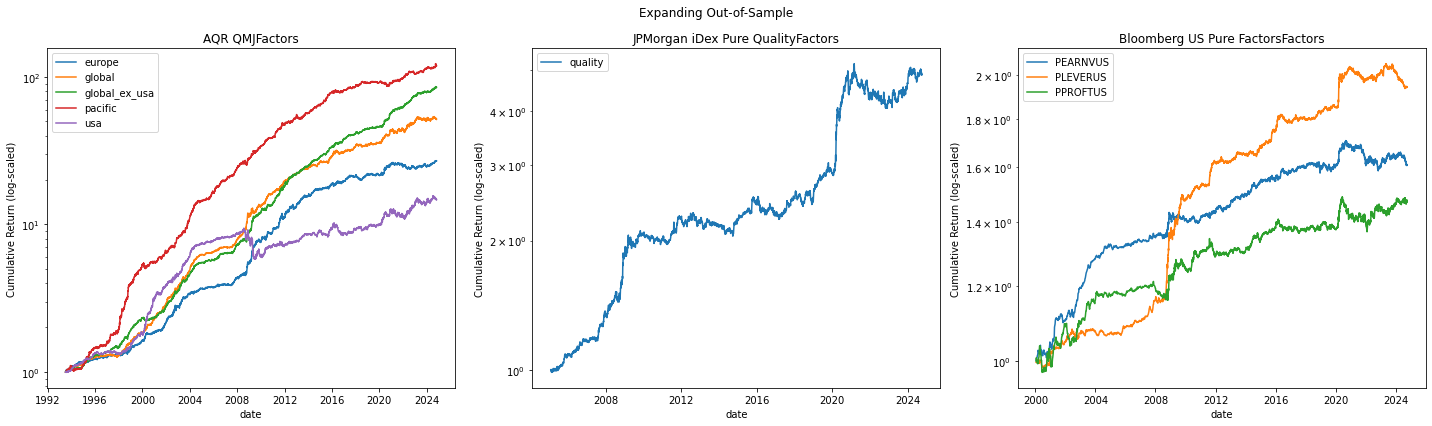

In [5]:
def plot_rtn(df: pd.DataFrame) -> plt.Figure:
    
    df_namer    = ExpandingOLS().get_expanding_ols()[["variable", "source"]].drop_duplicates()
    df_combined = (df.merge(
        right = df_namer, how = "inner", on = ["variable"]))
    
    renamer = {
        "AQR"      : "AQR QMJ",
        "JPM"      : "JPMorgan iDex Pure Quality",
        "bloomberg": "Bloomberg US Pure Factors"}

    groups    = df_combined.source.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(groups), figsize = (20,6))

    for group, ax in zip(groups, axes.flatten()):

        (df_combined.query(
            "source == @group").
            rename(columns = {"variable": ""}).
            pivot(index = "date", columns = "", values = "ex_rtn").
            dropna().
            apply(lambda x: np.cumprod(1 + x)).
            plot(
                ax     = ax,
                logy   = True,
                title  = renamer[group] + "Factors",
                ylabel = "Cumulative Return (log-scaled)"))

    fig.suptitle("Expanding Out-of-Sample")
    plt.tight_layout()
    
plot_rtn(df)

## Compare Returns

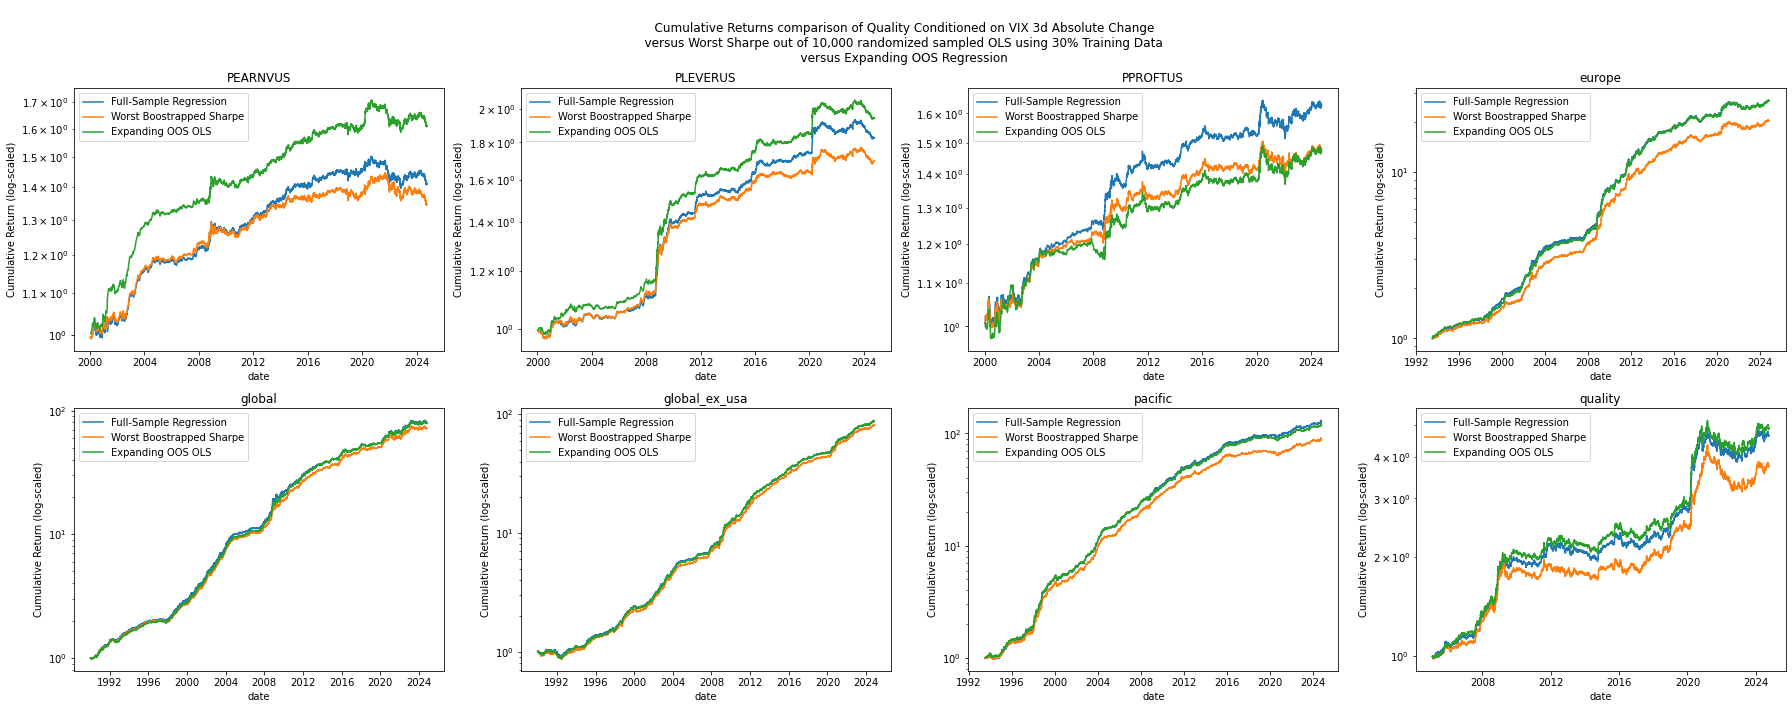

In [6]:
def compare_returns(df: pd.DataFrame) -> plt.Figure:     

    fig, axes = plt.subplots(ncols = 4, nrows = 2, figsize = (25,10))
    variables = df.variable.drop_duplicates().sort_values().to_list()

    for variable, ax in zip(variables, axes.flatten()):

        (df.query(
            "variable == @variable").
            set_index("date").
            drop(columns = ["variable", "value"]).
            rename(columns = {
                "fs_rtn": "Full-Sample Regression",
                "bs_rtn": "Worst Boostrapped Sharpe",
                "ex_rtn": "Expanding OOS OLS"}).
            apply(lambda x: np.cumprod(1 + x)).
            plot(
                ax     = ax,
                logy   = True,
                ylabel = "Cumulative Return (log-scaled)",
                title  = variable))
    
    fig.suptitle('''
    Cumulative Returns comparison of Quality Conditioned on VIX 3d Absolute Change
    versus Worst Sharpe out of 10,000 randomized sampled OLS using 30% Training Data
    versus Expanding OOS Regression''')
    plt.tight_layout()
    
compare_returns(df)

In [7]:
def get_shapre(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df.rename(
        columns = {
            "value"   : "raw_rtn",
            "variable": "region"}).
        melt(id_vars = ["region", "date"]).
        drop(columns = ["date"]).
        groupby(["variable", "region"]).
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df_out

df_sharpe = get_shapre(df)

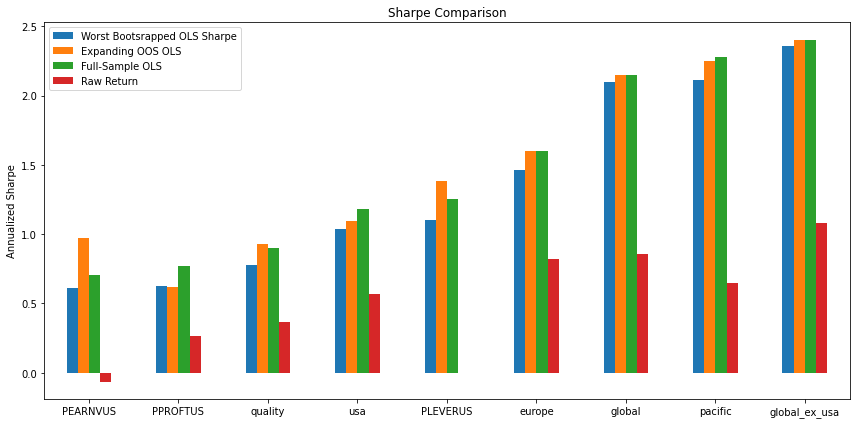

In [8]:
def plot_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure:
    
    (df_sharpe.rename(
        columns = {"variable": ""}).
        pivot(index = "region", columns = "", values = "sharpe").
        sort_values("bs_rtn").
        rename(columns = {
            "bs_rtn" : "Worst Bootsrapped OLS Sharpe",
            "ex_rtn" : "Expanding OOS OLS",
            "fs_rtn" : "Full-Sample OLS",
            "raw_rtn": "Raw Return"}).
        plot(
            title   = "Sharpe Comparison",
            kind    = "bar",
            rot     = 0,
            xlabel  = "",
            ylabel  = "Annualized Sharpe",
            figsize = (12,6)))
    
    plt.tight_layout()
    
plot_sharpe(df_sharpe)

In [9]:
def get_avg_port(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_avg = (df.rename(columns = {
        "value": "raw_rtn",
        "variable": "region"}).
        melt(id_vars = ["region", "date"]).
        drop(columns = ["region"]).
        groupby(["date", "variable"]).
        agg("mean").
        reset_index())
    
    return df_avg

df_avg = get_avg_port(df)

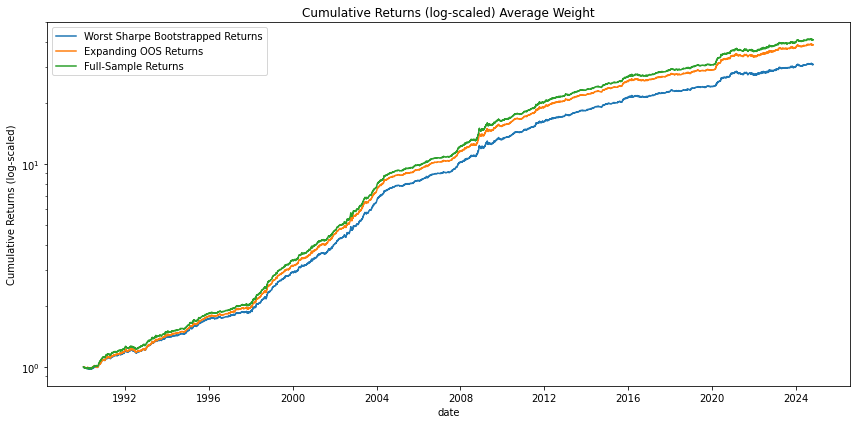

In [10]:
def plot_avg(df_avg: pd.DataFrame) -> plt.Figure:     

    (df_avg.query(
        "variable != 'raw_rtn'").
        rename(columns = {"variable": ""}).
        pivot(index = "date", columns = "", values = "value").
        apply(lambda x: np.cumprod(1 + x)).
        rename(columns = {
            "bs_rtn": "Worst Sharpe Bootstrapped Returns",
            "ex_rtn": "Expanding OOS Returns",
            "fs_rtn": "Full-Sample Returns"}).
        plot(
            logy    = True,
            figsize = (12,6),
            title   = "Cumulative Returns (log-scaled) Average Weight",
            ylabel  = "Cumulative Returns (log-scaled)"))
    
    plt.tight_layout()
    
plot_avg(df_avg)

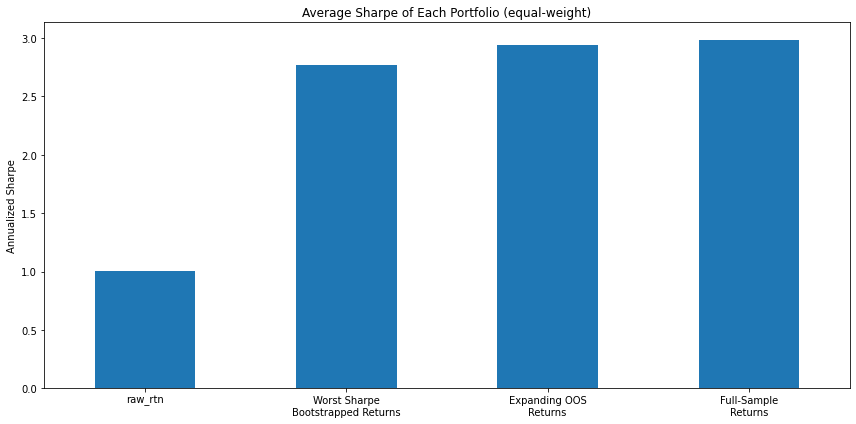

In [11]:
def plot_sharpe(df_avg: pd.DataFrame) -> plt.Figure: 
    
    replacer = {
        "bs_rtn": "Worst Sharpe\nBootstrapped Returns",
        "ex_rtn": "Expanding OOS\nReturns",
        "fs_rtn": "Full-Sample\nReturns"}

    (df_avg.drop(
        columns = ["date"]).
        replace(replacer).
        groupby("variable").
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe"]].
        sort_values("sharpe").
        plot(
            kind    = "bar",
            figsize = (12,6),
            rot     = 0,
            xlabel  = "",
            legend  = False,
            title   = "Average Sharpe of Each Portfolio (equal-weight)",
            ylabel  = "Annualized Sharpe"))
    
    plt.tight_layout()
    
plot_sharpe(df_avg)

In [12]:
def _add_tc(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "date").
        assign(
            raw_sig = lambda x: np.sign(x.lag_resid),
            lag_sig = lambda x: x.raw_sig.shift(),
            tc      = lambda x: np.where(x.raw_sig == x.lag_sig, 0, -0.0003),
            tc_rtn  = lambda x: x.tc + x.signal_rtn))
    
    return df_out

def get_tc(df_ex_rtn: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df_ex_rtn.groupby(
        "variable").
        apply(_add_tc).
        drop(columns = ["variable"]).
        reset_index().
        drop(columns = ["level_1"]))
    
    return df_out

df_tc = get_tc(df_ex_rtn)

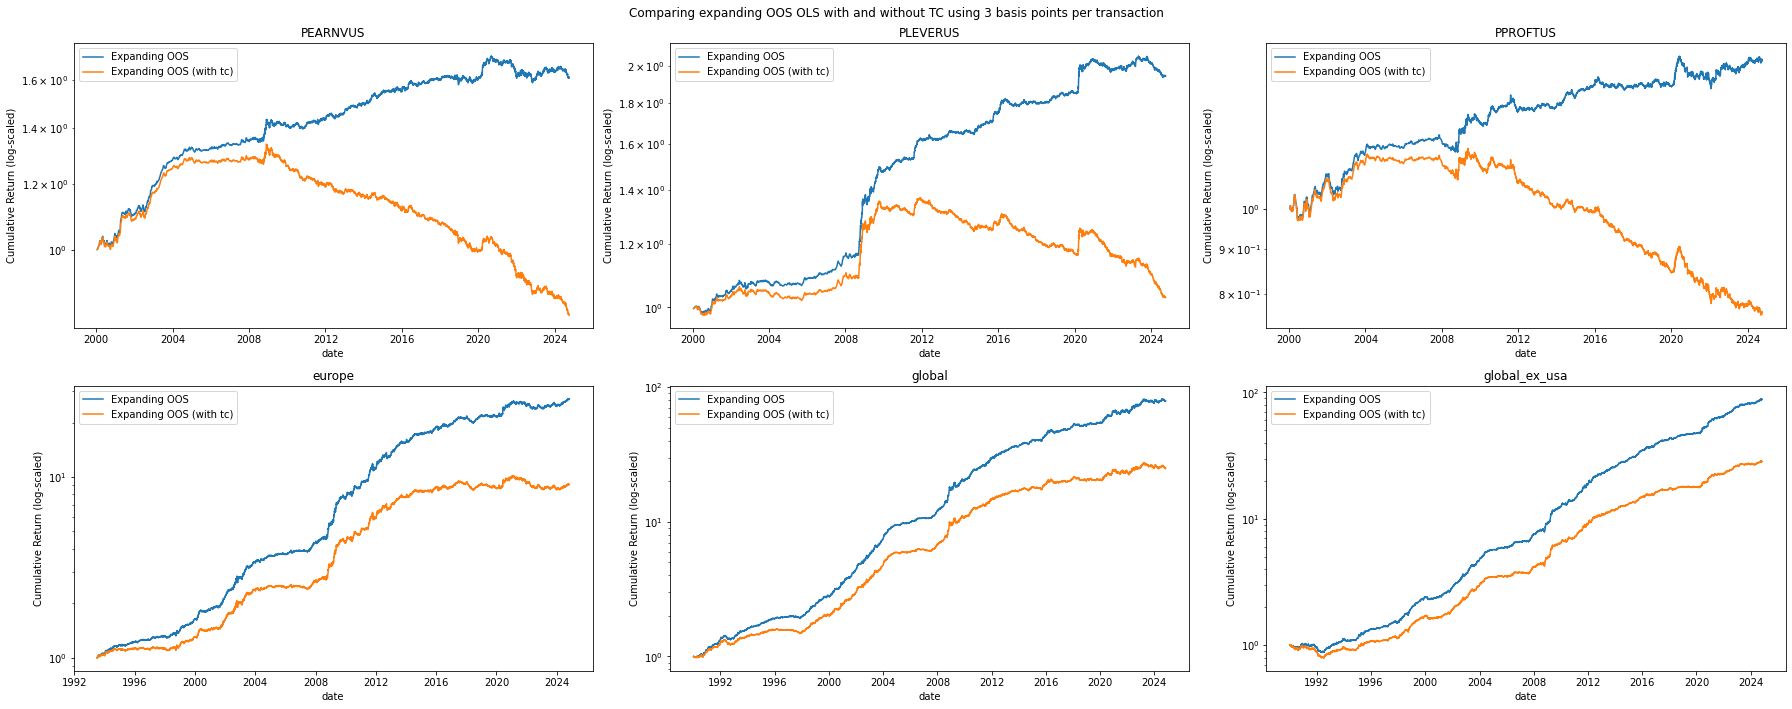

In [13]:
def plot_quality_tc(df_tc: pd.DataFrame) -> plt.Figure: 

    fig, axes = plt.subplots(ncols = 3, nrows = 2, figsize = (25,10))
    variables = df_tc.variable.drop_duplicates().sort_values().to_list()

    for variable, ax in zip(variables, axes.flatten()):

        (df_tc.query(
            "variable == @variable").
            set_index("date")
            [["signal_rtn", "tc_rtn"]].
            rename(columns = {
                "signal_rtn": "Expanding OOS",
                "tc_rtn"    : "Expanding OOS (with tc)"}).
            apply(lambda x: np.cumprod(1 + x)).
            plot(
                title  = variable,
                ax     = ax,
                logy   = True,
                ylabel = "Cumulative Return (log-scaled)"))

    fig.suptitle("Comparing expanding OOS OLS with and without TC using 3 basis points per transaction")
    plt.tight_layout()
    
plot_quality_tc(df_tc)

In [14]:
def get_tc_sharpe(df_tc: pd.DataFrame) -> pd.DataFrame: 
    
    df_tc_sharpe = (df_tc[
        ["variable", "date", "signal_rtn", "tc_rtn"]].
        rename(columns = {"variable": "region"}).
        melt(id_vars = ["date", "region"]).
        drop(columns = ["date"]).
        groupby(["region", "variable"]).
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df_tc_sharpe
    
df_tc_sharpe = get_tc_sharpe(df_tc)

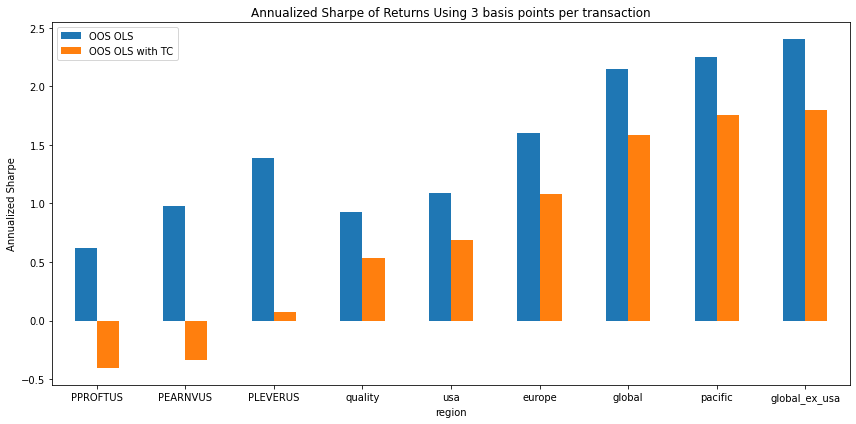

In [15]:
def plot_tc_sharpe(df_tc_sharpe: pd.DataFrame) -> plt.Figure: 
    
    (df_tc_sharpe.rename(
        columns = {"variable": ""}).
        pivot(index = "region", columns = "", values = "sharpe").
        sort_values("tc_rtn").
        rename(columns = {
            "signal_rtn": "OOS OLS",
            "tc_rtn"    : "OOS OLS with TC"}).
        plot(
            figsize = (12,6),
            kind    = "bar",
            rot     =  0,
            ylabel  = "Annualized Sharpe",
            title   = "Annualized Sharpe of Returns Using 3 basis points per transaction"))

    plt.tight_layout()
    
plot_tc_sharpe(df_tc_sharpe)

In [16]:
def _tc(df: pd.DataFrame, tc: float) -> pd.DataFrame: 
    
    df_out = (df.assign(
        raw_signal  = lambda x: np.sign(x.lag_resid),
        prev_signal = lambda x: x.raw_signal.shift(),
        tc          = lambda x: np.where(x.raw_signal == x.prev_signal, 0, tc),
        tc_rtn      = lambda x: x.signal_rtn - x.tc))
    
    return df_out

def _add_var_tc(df: pd.DataFrame, tcs: list) -> pd.DataFrame: 
    
    df_out = (pd.concat([
        _tc(df, tc).assign(tc_cost = tc) 
        for tc in tcs]))
    
    df_out = (df_out[
        ["tc_cost", "tc_rtn"]].
        groupby("tc_cost").
        agg(["mean", "std"])
        ["tc_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)))
    
    return df_out
    
def var_tc(df_ex_rtn: pd.DataFrame) -> pd.DataFrame: 

    tcs = [(i + 1) / 10_000 for i in range(50)]

    df_out = (df_ex_rtn.groupby(
        "variable").
        apply(_add_var_tc, tcs).
        reset_index())
    
    return df_out
    
df_tc_change = var_tc(df_ex_rtn)

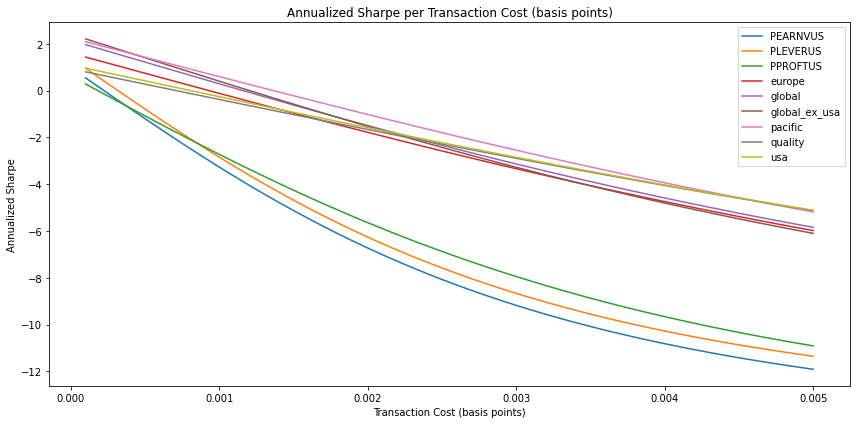

In [17]:
def plot_tc_change(df: pd.DataFrame) -> plt.Figure: 
    
    (df_tc_change.rename(
        columns = {"variable": ""}).
        pivot(index ="tc_cost", columns = "", values = "sharpe").
        plot(
            ylabel = "Annualized Sharpe",
            xlabel = "Transaction Cost (basis points)",
            figsize = (12,6),
            title   = "Annualized Sharpe per Transaction Cost (basis points)"))

    plt.tight_layout()
    
plot_tc_change(df)